In [1]:
import pymysql
import pandas as pd
import datetime 

## 数据预处理

#### 从数据库获取数据

In [2]:
def getdata():
    data=[]
    db=pymysql.connect(host='1.119.44.200',port=30002,user='root',password='bdctableau',db='data_portal')
    cursor=db.cursor()
    sql="select * from ads_all_d_zc_tsg_zjc_fssj where fssj>='2020-01-01' order by fssj asc"
    try:
        cursor.execute(sql)
        #data=db.commit()
        #print(data)
        ## 将单条数据存入list中
        for line in cursor.fetchall():
            data.append(line)
    except Exception as e:
        #print(e)
        db.rollback()  
    db.close()
    
    return data
    

#### 需要将‘时间’单维度扩展为多维度：   
--1、年  
--2、月  
--3、日  
4、季节：春(3-5)：0，夏(6-8)：1 ，秋(9-11)：2，冬(12-2)：3  
5、上学期(9月-12月)：0，寒假（1月-2月）:1,下学期（3月-6月）：2，暑假（7月-8月）：3  
6、每周七天：周一：1....周天：7  


####  获取季节、学期信息

In [3]:
def large_date(yf):
        #季节
    if  yf>=3 and yf<=5:
        jj=0
    elif yf>=6 and yf<=8:
        jj=1
    elif yf>=9 and yf<=11:
        jj=2
    else:
        jj=3
    
        #学期
    if  yf>=9 and yf<=12:
        xq=0
    elif yf>=1 and yf<=2:
        xq=1
    elif yf>=3 and yf<=6:
        xq=2
    else:
        xq=3
        
    return jj,xq

#### 将读取的数据转化为Dateframe格式

In [4]:

#data_one=[]
#tomm=datetime.datetime.strptime('2019-12-31', "%Y-%m-%d")
#tom=datetime.datetime.strptime('2019-12-31', "%Y-%m-%d")
data_all=[]
data=getdata()
data
for dt in data:
    tomm=dt[0]
#     if dt[0]==(tomm+datetime.timedelta(days=1)):
#         tomm=dt[0]
#         count=int(dt[1])
        
#     else:
#         tomm=(tomm+datetime.timedelta(days=1))
#         count=0
    
    
    data_one=[]
    data_one.append(tomm)
    data_one.append(int(tomm.strftime('%Y')))
    data_one.append(int(tomm.strftime('%m')))
    data_one.append(int(tomm.strftime('%d')))
    
    yf=int(tomm.strftime('%m'))
    
    jj,xq=large_date(yf)
    data_one.append(jj)
    

    data_one.append(xq)
    # 星期
    data_one.append(tomm.weekday()+1)
    
    data_one.append(dt[1])
    data_all.append(data_one)
df = pd.DataFrame(data_all, columns=['Date', 'Year', 'Month','Day','Season','Term','Weekday','Count']).set_index('Date', drop=True) 
        
        

In [5]:
df

,Year,Month,Day,Season,Term,Weekday,Count
Date,,,,,,,
2020-02-04,2020,2,4,3,1,2,2
2020-02-24,2020,2,24,3,1,1,2
2020-02-28,2020,2,28,3,1,5,2
2020-03-01,2020,3,1,0,2,7,2
2020-03-06,2020,3,6,0,2,5,2
...,...,...,...,...,...,...,...
2021-03-02,2021,3,2,0,2,2,10
2021-03-03,2021,3,3,0,2,3,12
2021-03-04,2021,3,4,0,2,4,6


#### 由于中间有时间缺失，需要补充时间及进入图书馆的人数

In [6]:
i = datetime.date(2020, 1, 1)  # 默认将i设为数据的起始时间
# 判断起始日（2020-01-01）是否有数据，若不存在则将起始日的数据进行添加
if i not in df.index.values.tolist():
    # ps：需要设置索引
    new = pd.DataFrame({'Year': 2020, 'Month': 1, 'Day': 1, 'Season': 3, 'Term': 1, 'Weekday': 3, 'Count': 0},
                       index=[i])   # 自定义索引为：i ，这里也可以不设置index
    # df[df.index==i]=[2020,1,1,3,1,3,0]
    df = df.append(new, ignore_index=False)
## 进行数据缺失的检测：缺失增添数据规则：使用前一周的同一星期进行填充（eg：本周三数据缺失，使用上一周的周三数据(若存在数据)填充）
while i <= datetime.date(2021, 6, 30):
    if i not in df.index.values.tolist():
        ## 季节和学期信息
        yf = int(i.strftime('%m'))
        jj, xq = large_date(yf)
        # 获取此日期前一周的同一天时间
        i_7last = i-datetime.timedelta(days=7)
        ## 星期信息
        week = i.weekday()+1
        # 判断前七天的数据是否在读取的数据内
        if i_7last >= datetime.date(2020, 1, 1):  # 如果前一周的数据在所获取的数据的范围内：
            # df[i]=[int(i.strftime('%Y')),int(i.strftime('%m')),int(i.strftime('%d')),jj,xq,week,df[i_7last]['Count']]
            count=df.iloc[df.index==i_7last]['Count']
        else:  # 若所获取的数据不在范围内，则取前一天的数据：
            i_1last = i-datetime.timedelta(days=1)
            # df[i]=[int(i.strftime('%Y')),int(i.strftime('%m')),int(i.strftime('%d')),jj,xq,week,df[i_1last]['Count']]
            count=df.iloc[df.index==i_1last]['Count']
        new=pd.DataFrame({'Year': int(i.strftime('%Y')), 'Month': int(i.strftime('%m')), 'Day': int(i.strftime('%d')), 'Season': jj, 'Term': xq, 'Weekday': week, 'Count': 0},index=[i])
        df = df.append(new, ignore_index=False)
    i = i+datetime.timedelta(days=1)

In [7]:
df=df.sort_index()

## 数据集划分

将2020-01-01～2020-12-31的数据划分为训练集  
2021-01-01～2021-06-30的数据划分为测试集

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D

/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yth/anaconda3/envs/predict/lib/python3.6/site-

In [9]:
df.shape

(547, 7)

In [10]:
df.iloc[df.index==datetime.date(2020,1,6)]

,Year,Month,Day,Season,Term,Weekday,Count
2020-01-06,2020,1,6,3,1,1,0


In [11]:
df.iloc[df.index==datetime.date(2021,1,4)]

,Year,Month,Day,Season,Term,Weekday,Count
2021-01-04,2021,1,4,3,1,1,8


In [12]:
df.iloc[df.index==datetime.date(2021,6,27)]

,Year,Month,Day,Season,Term,Weekday,Count
2021-06-27,2021,6,27,1,2,7,0


将2020-01-06～2021.1.3划分为训练集   
2021.1.4～2021.6.27 划分为测试集

In [13]:
df[5:369]

,Year,Month,Day,Season,Term,Weekday,Count
2020-01-06,2020,1,6,3,1,1,0
2020-01-07,2020,1,7,3,1,2,0
2020-01-08,2020,1,8,3,1,3,0
2020-01-09,2020,1,9,3,1,4,0
2020-01-10,2020,1,10,3,1,5,0
...,...,...,...,...,...,...,...
2020-12-30,2020,12,30,3,0,3,4209
2020-12-31,2020,12,31,3,0,4,1541
2021-01-01,2021,1,1,3,1,5,0
2021-01-02,2021,1,2,3,1,6,0


In [14]:
df[369:-3]

,Year,Month,Day,Season,Term,Weekday,Count
2021-01-04,2021,1,4,3,1,1,8
2021-01-05,2021,1,5,3,1,2,0
2021-01-06,2021,1,6,3,1,3,2
2021-01-07,2021,1,7,3,1,4,6
2021-01-08,2021,1,8,3,1,5,0
...,...,...,...,...,...,...,...
2021-06-23,2021,6,23,1,2,3,0
2021-06-24,2021,6,24,1,2,4,0
2021-06-25,2021,6,25,1,2,5,0
2021-06-26,2021,6,26,1,2,6,0


In [15]:
## 划分数据集
def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为统计数据，shape为(547, 7)
    train, test = data[5:369], data[369:-3]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

## 模型 CNN

In [ ]:

# def evaluate_forecasts(actual, predicted):
#     '''
#     该函数实现根据预期值评估一个或多个周预测损失
#     思路：统计所有单日预测的 RMSE
#     '''
#     scores = list()
#     for i in range(actual.shape[1]):
#         mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
#         rmse = math.sqrt(mse)
#         scores.append(rmse)
    
#     s = 0 # 计算总的 RMSE
#     for row in range(actual.shape[0]):
#         for col in range(actual.shape[1]):
#             s += (actual[row, col] - predicted[row, col]) ** 2
#     score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
#     print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
#     return score, scores

# def summarize_scores(name, score, scores):
#     s_scores = ', '.join(['%.1f' % s for s in scores])
#     print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
# def sliding_window(train, sw_width=7, n_out=7, in_start=0):
#     '''
#     该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
#     '''
#     data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
#     X, y = [], []
    
#     for _ in range(len(data)):
#         in_end = in_start + sw_width
#         out_end = in_end + n_out
        
#         # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
#         if out_end < len(data):
#             # 训练数据以滑动步长1截取
#             train_seq = data[in_start:in_end, 0]
#             train_seq = train_seq.reshape((len(train_seq), 1))
#             X.append(train_seq)
#             y.append(data[in_end:out_end, 0])
#         in_start += 1
        
#     return np.array(X), np.array(y)

# def cnn_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
#     '''
#     该函数定义 1D CNN 模型
#     '''
#     train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
#     n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
#     model = Sequential()
#     model.add(Conv1D(filters=16, kernel_size=3, activation='relu', 
#                      input_shape=(n_timesteps, n_features)))
    
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(units=n_outputs))
    
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    
#     model.fit(train_x, train_y,
#               epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
#     return model

# def forecast(model, pred_seq, sw_width):
#     '''
#     该函数实现对输入数据的预测
#     '''
#     data = np.array(pred_seq)
#     data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
#     input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
#     input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
#     yhat = model.predict(input_x, verbose=0) # 预测下周数据
#     yhat = yhat[0] # 获取预测向量
#     return yhat

# def evaluate_model(model, train, test, sd_width):
#     '''
#     该函数实现模型评估
#     '''
#     history_fore = [x for x in train]
#     predictions = list() # 用于保存每周的前向验证结果；
#     for i in range(len(test)):
#         yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
#         predictions.append(yhat_sequence) # 保存预测结果
#         history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
#     predictions = np.array(predictions) # 评估一周中每天的预测结果
#     score, scores = evaluate_forecasts(test[:, :, 0], predictions)
#     return score, scores

# def model_plot(score, scores, days, name):
#     '''
#     该函数实现绘制RMSE曲线图
#     '''
#     plt.figure(figsize=(8,6), dpi=150)
#     plt.plot(days, scores, marker='o', label=name)
#     plt.grid(linestyle='--', alpha=0.5)
#     plt.ylabel(r'$RMSE$', size=15)
#     plt.title('CNN 模型预测结果',  size=18)
#     plt.legend()
#     plt.show()
    
# def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
#     '''
#     主函数：数据处理、模型训练流程
#     '''
#     # 划分训练集和测试集
#     train, test = split_dataset(dataset.values)
#     # 训练模型
#     model = cnn_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
#     # 计算RMSE
#     score, scores = evaluate_model(model, train, test, sw_width)
#     # 打印分数
#     summarize_scores(name, score, scores)
#     # 绘图
#     model_plot(score, scores, days, name)
        
# if __name__ == '__main__':
    
# #     dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
# #                    infer_datetime_format=True, engine='c',
# #                    parse_dates=['datetime'], index_col=['datetime'])
#     dateset=df
#     days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#     name = 'cnn'
    
#     sliding_window_width=7
#     input_sequence_start=0
    
#     epochs_num=20
#     batch_size_set=4
#     verbose_set=0
    
#     main_run(dateset, sliding_window_width, days, name, input_sequence_start,
#              verbose_set, epochs_num, batch_size_set)


## 训练模型LSTM

In [16]:
import tensorflow as tf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________
None


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22411 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32467 missing from current f

actual.shape[0]:25, actual.shape[1]:7
LSTM: [0.135] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1



/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22411 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 32467 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yth/anaconda3/envs/predict/lib/python3.

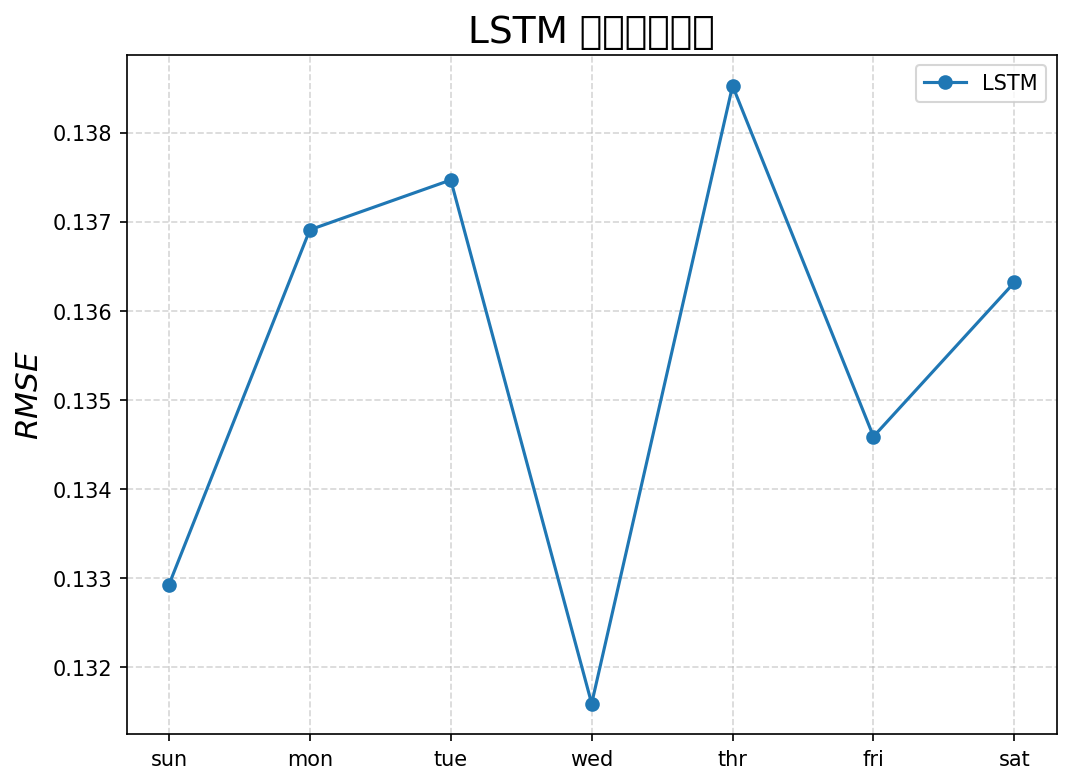

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# def split_dataset(data):
#     '''
#     该函数实现以周为单位切分训练数据和测试数据
#     '''
#     # data为按天的耗电量统计数据，shape为(1442, 8)
#     # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
#     train, test = data[1:-328], data[-328:-6]
#     train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
#     test = np.array(np.split(test, len(test)/7))
#     return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 LSTM 模型
    单变量
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('LSTM 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    save_path='predict_tsg_num.h5'
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    #  保存模型
    model.save(save_path)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)

    
if __name__ == '__main__':
    
#     dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
#                    infer_datetime_format=True, engine='c',
#                    parse_dates=['datetime'], index_col=['datetime'])
    dataset=df
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'LSTM'
    
    sliding_window_width= 7
    input_sequence_start=0
    
    epochs_num=70
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)


In [ ]:

# forecast(model, pred_seq, 7)

In [ ]:
# def main_run1(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
#     '''
#     主函数：数据处理、模型训练流程
#     '''
#     # 划分训练集和测试集
#     train, test = split_dataset(dataset.values)
#     # 训练模型
#     model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
#     history_fore = [x for x in train]
#     forcast=forecast(model, history_fore, sw_width)
#     print(forcast)
# if __name__ == '__main__':
    
# #     dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
# #                    infer_datetime_format=True, engine='c',
# #                    parse_dates=['datetime'], index_col=['datetime'])
#     dataset=df
#     days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#     name = 'LSTM'
    
#     sliding_window_width= 7
#     input_sequence_start=0
    
#     epochs_num=70
#     batch_size_set=16
#     verbose_set=0
    
    
#     main_run1(dataset, sliding_window_width, days, name, input_sequence_start,
#              verbose_set, epochs_num, batch_size_set)
